In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import matlab.engine
from scipy.stats import norm


## Greeks


In [97]:
def delta(S, K, r, sigma_imp, T, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    if option_type == 'C':
        return norm.cdf(d1)
    elif option_type == 'P':
        return -norm.cdf(-d1)

def theta(S, K, r, sigma_imp, T, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    d2 = d1 - sigma_imp * np.sqrt(T)
    if option_type == 'C':
        return -S * norm.pdf(d1) * sigma_imp / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'P':
        return -S * norm.pdf(d1) * sigma_imp / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)

def gamma(S, K, r, sigma_imp, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    return norm.pdf(d1) / (S * sigma_imp * np.sqrt(T))

def vega(S, K, r, sigma_imp, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def rho(S, K, r, sigma_imp, T, option_type):
    d2 = (np.log(S / K) + (r - 0.5 * sigma_imp ** 2) * T) / (sigma_imp * np.sqrt(T))
    if option_type == 'C':
        return K * T * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'P':
        return -K * T * np.exp(-r * T) * norm.cdf(-d2)

In [98]:
with open('expirations_with_data.txt', 'r') as file:
    expirations = [line.strip() for line in file.readlines()]

In [99]:
expirations[-1]

'2021-12-22'

In [ ]:
#t0 = df['quote_datetime'].iloc[0].split()[0]]
t0 = "2021-04-26"
T = "2022-04-26" # 1 year from t0
t_dates = expirations
tau = [(datetime.strptime(T, '%Y-%m-%d') - datetime.strptime(t, '%Y-%m-%d')).days for t in t_dates]

print(t_dates)
print(tau)

['2021-04-28', '2021-05-05', '2021-05-12', '2021-05-19', '2021-05-26', '2021-06-16', '2021-07-21', '2021-08-18', '2021-09-15', '2021-10-20', '2021-11-17', '2021-12-22']
[363, 356, 349, 342, 335, 314, 279, 251, 223, 188, 160, 125]


In [101]:
for expiration in expirations:
    df = pd.read_csv(fr'implied\vix_options_{expiration}.csv')
    index_count = 0
    T =tau[index_count]/365
    for option in df.iterrows():
        option = option[1]
        option_type = option['option_type']
        S = option['underlying_bid']
        K = option['strike']
        r = 0.045
        sigma_imp = option['implied_vol']
        option_delta = delta(S, K, r, sigma_imp, T, option_type)
        option_theta = theta(S, K, r, sigma_imp, T, option_type)
        option_gamma = gamma(S, K, r, sigma_imp, T)
        option_vega = vega(S, K, r, sigma_imp, T)
        option_rho = rho(S, K, r, sigma_imp, T, option_type)
        df.loc[option.name, 'delta'] = option_delta
        df.loc[option.name, 'theta'] = option_theta
        df.loc[option.name, 'gamma'] = option_gamma
        df.loc[option.name, 'vega'] = option_vega
        df.loc[option.name, 'rho'] = option_rho
    df.to_csv(fr'impliedcalc\vix_options_{expiration}.csv', index=False)
    index_count += 1



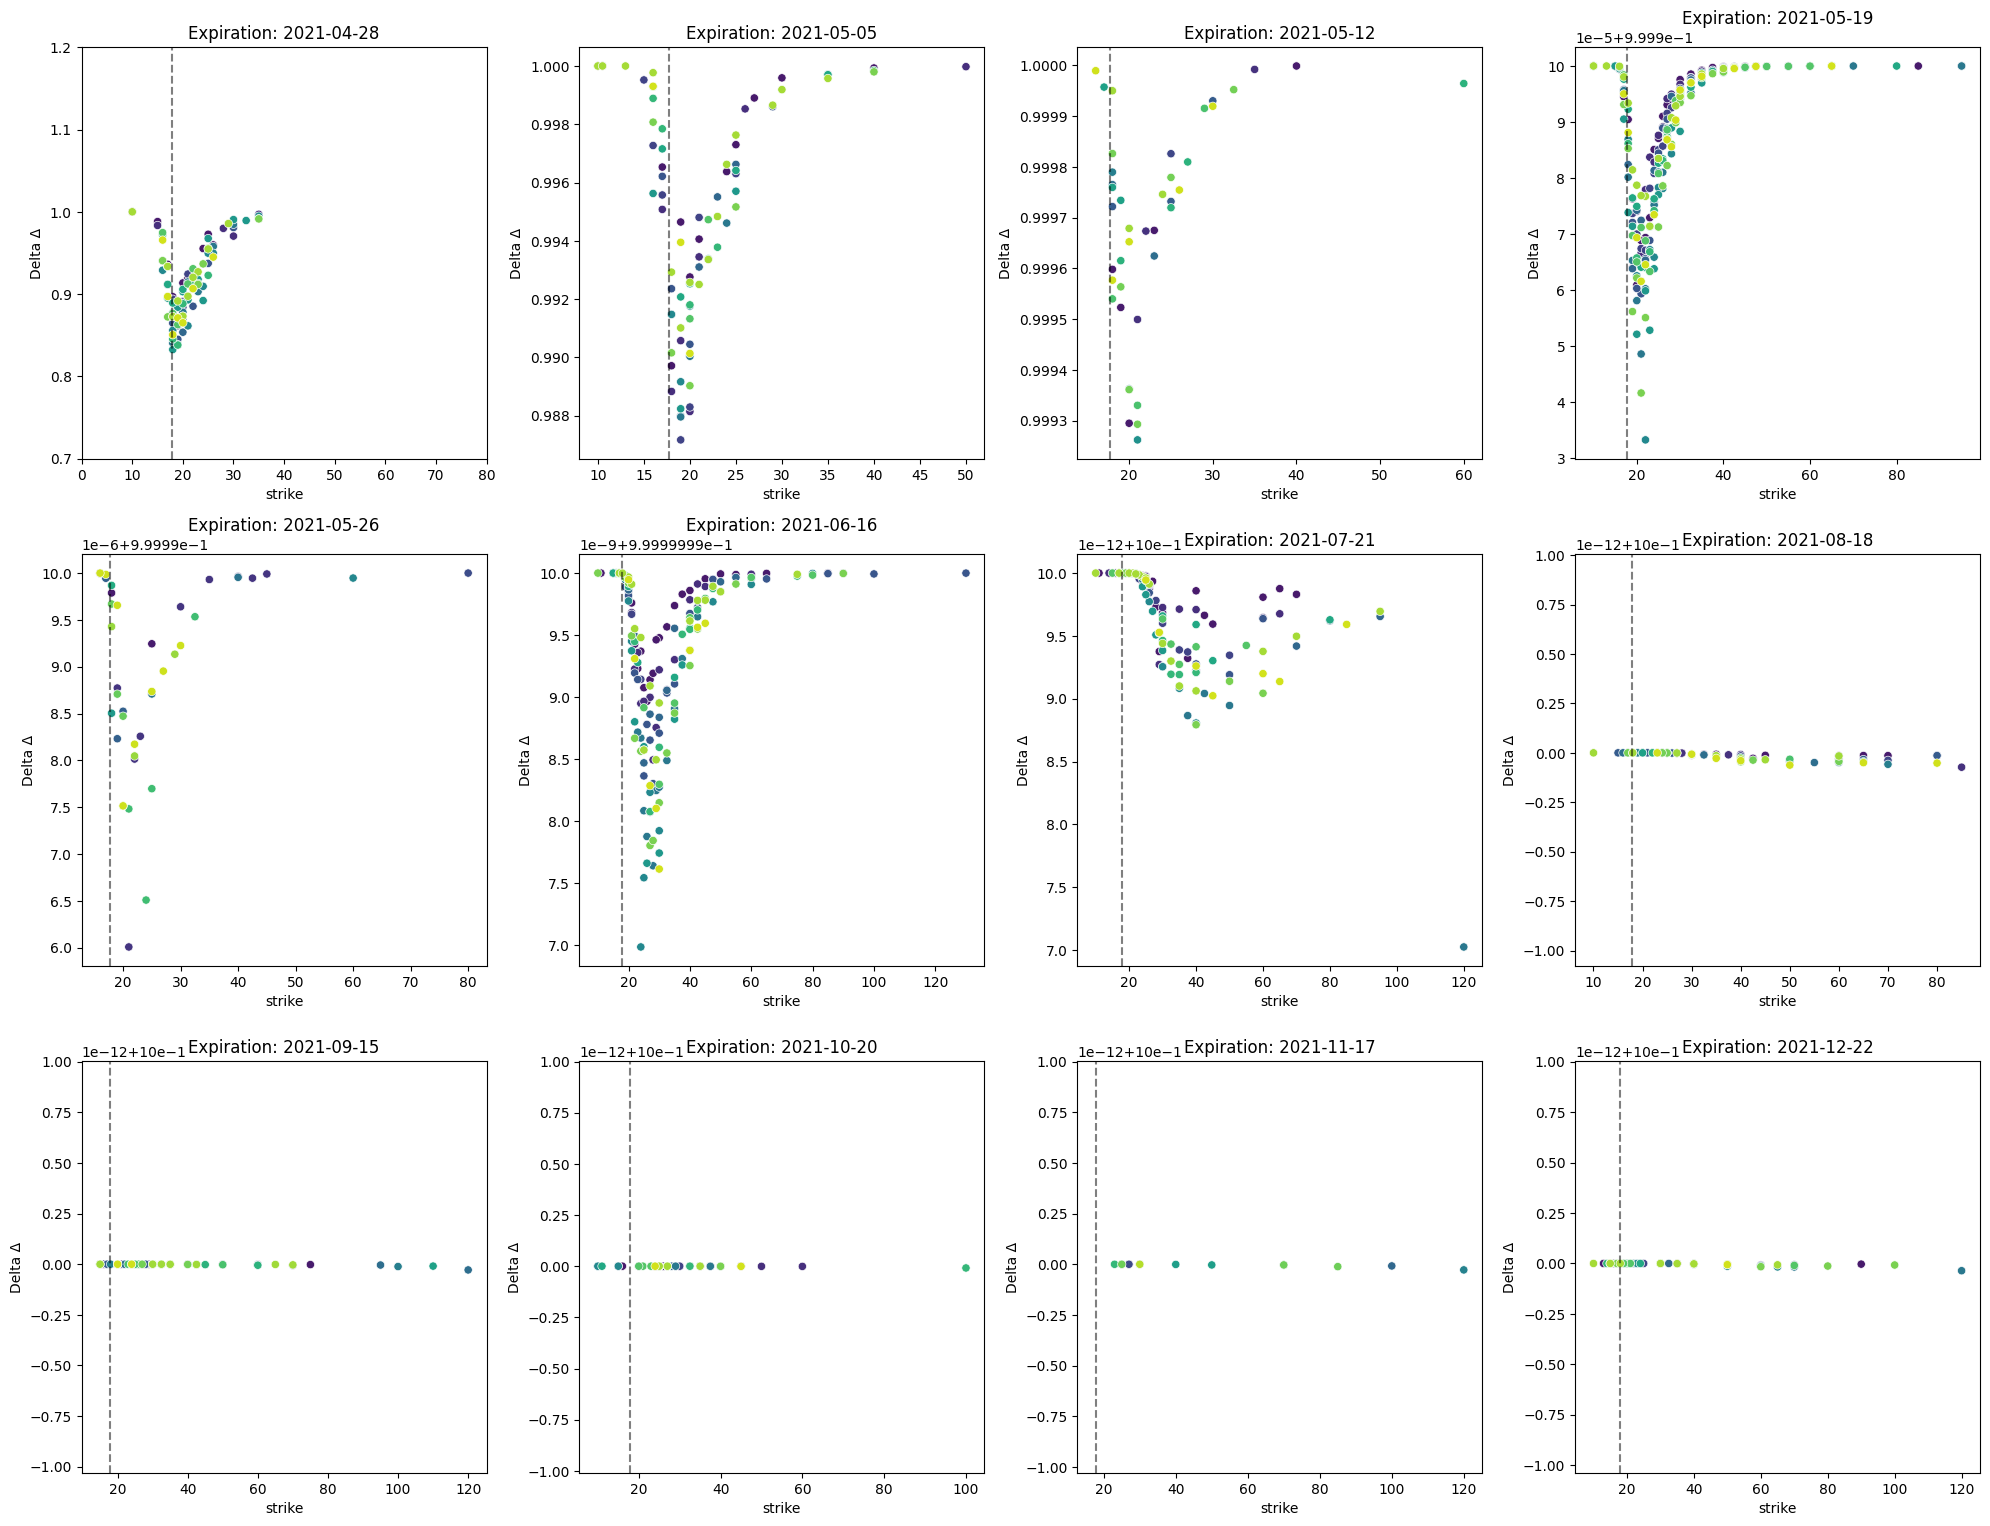

In [102]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='delta', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('Delta \u0394')
    if i == 0:
        axes[i].set_ylim(0.7,1.2)
        axes[i].set_xlim(0, 80)
    axes[i].set_title(f'Expiration: {expiration}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

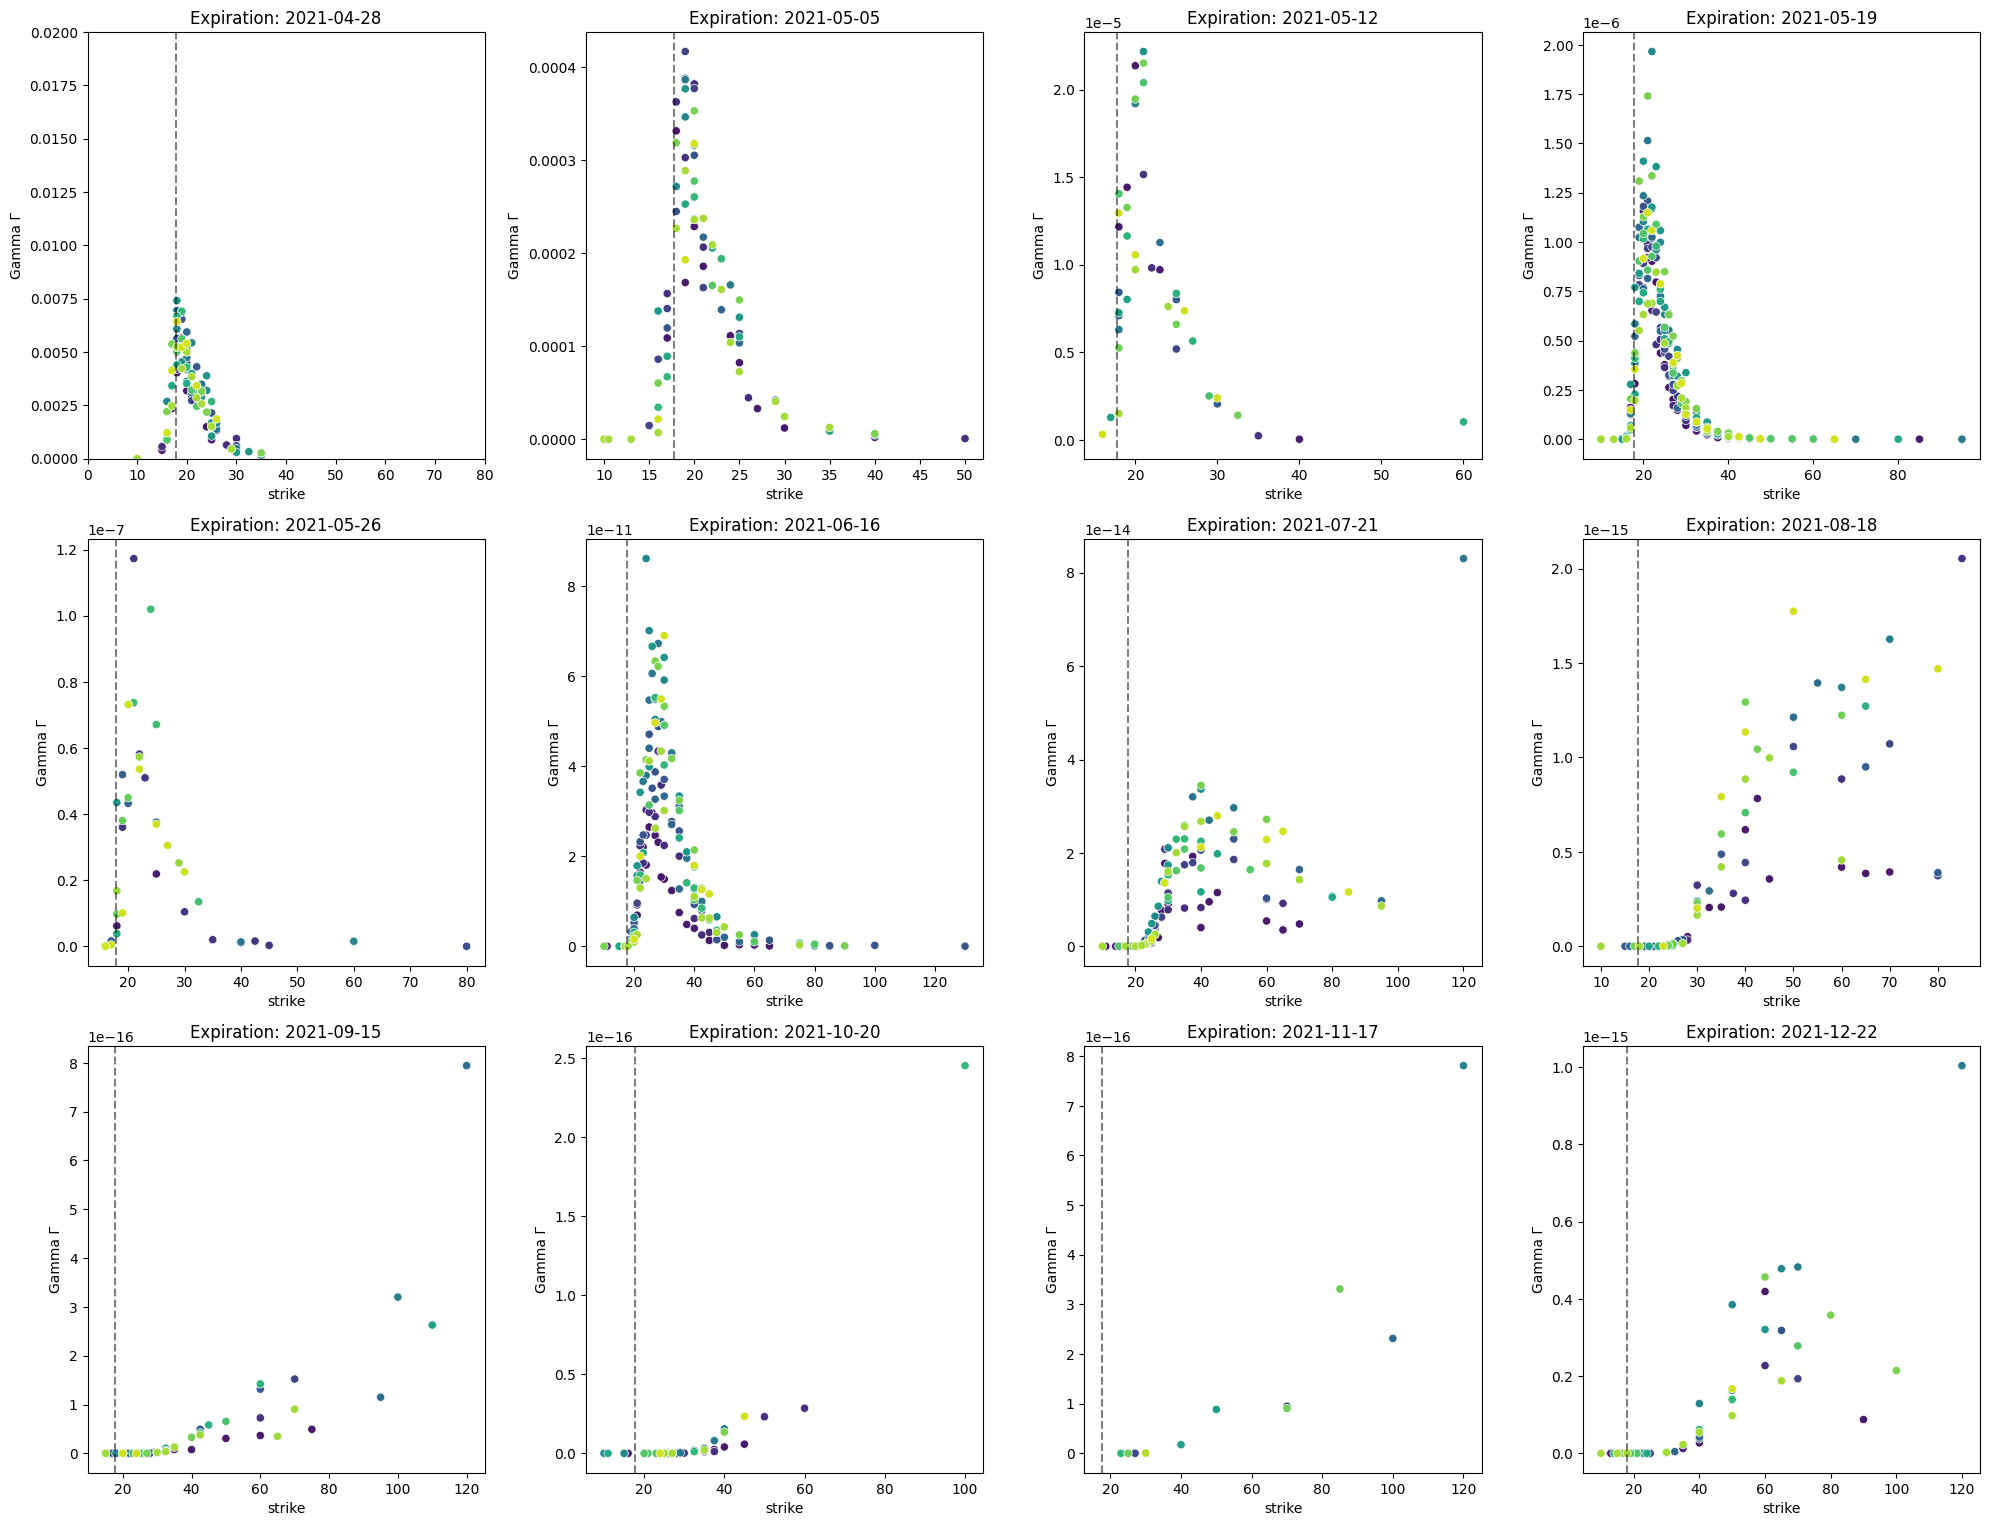

In [103]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='gamma', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('Gamma \u0393')
    if i == 0:
        axes[i].set_ylim(0.0,0.02)
        axes[i].set_xlim(0, 80)
    axes[i].set_title(f'Expiration: {expiration}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

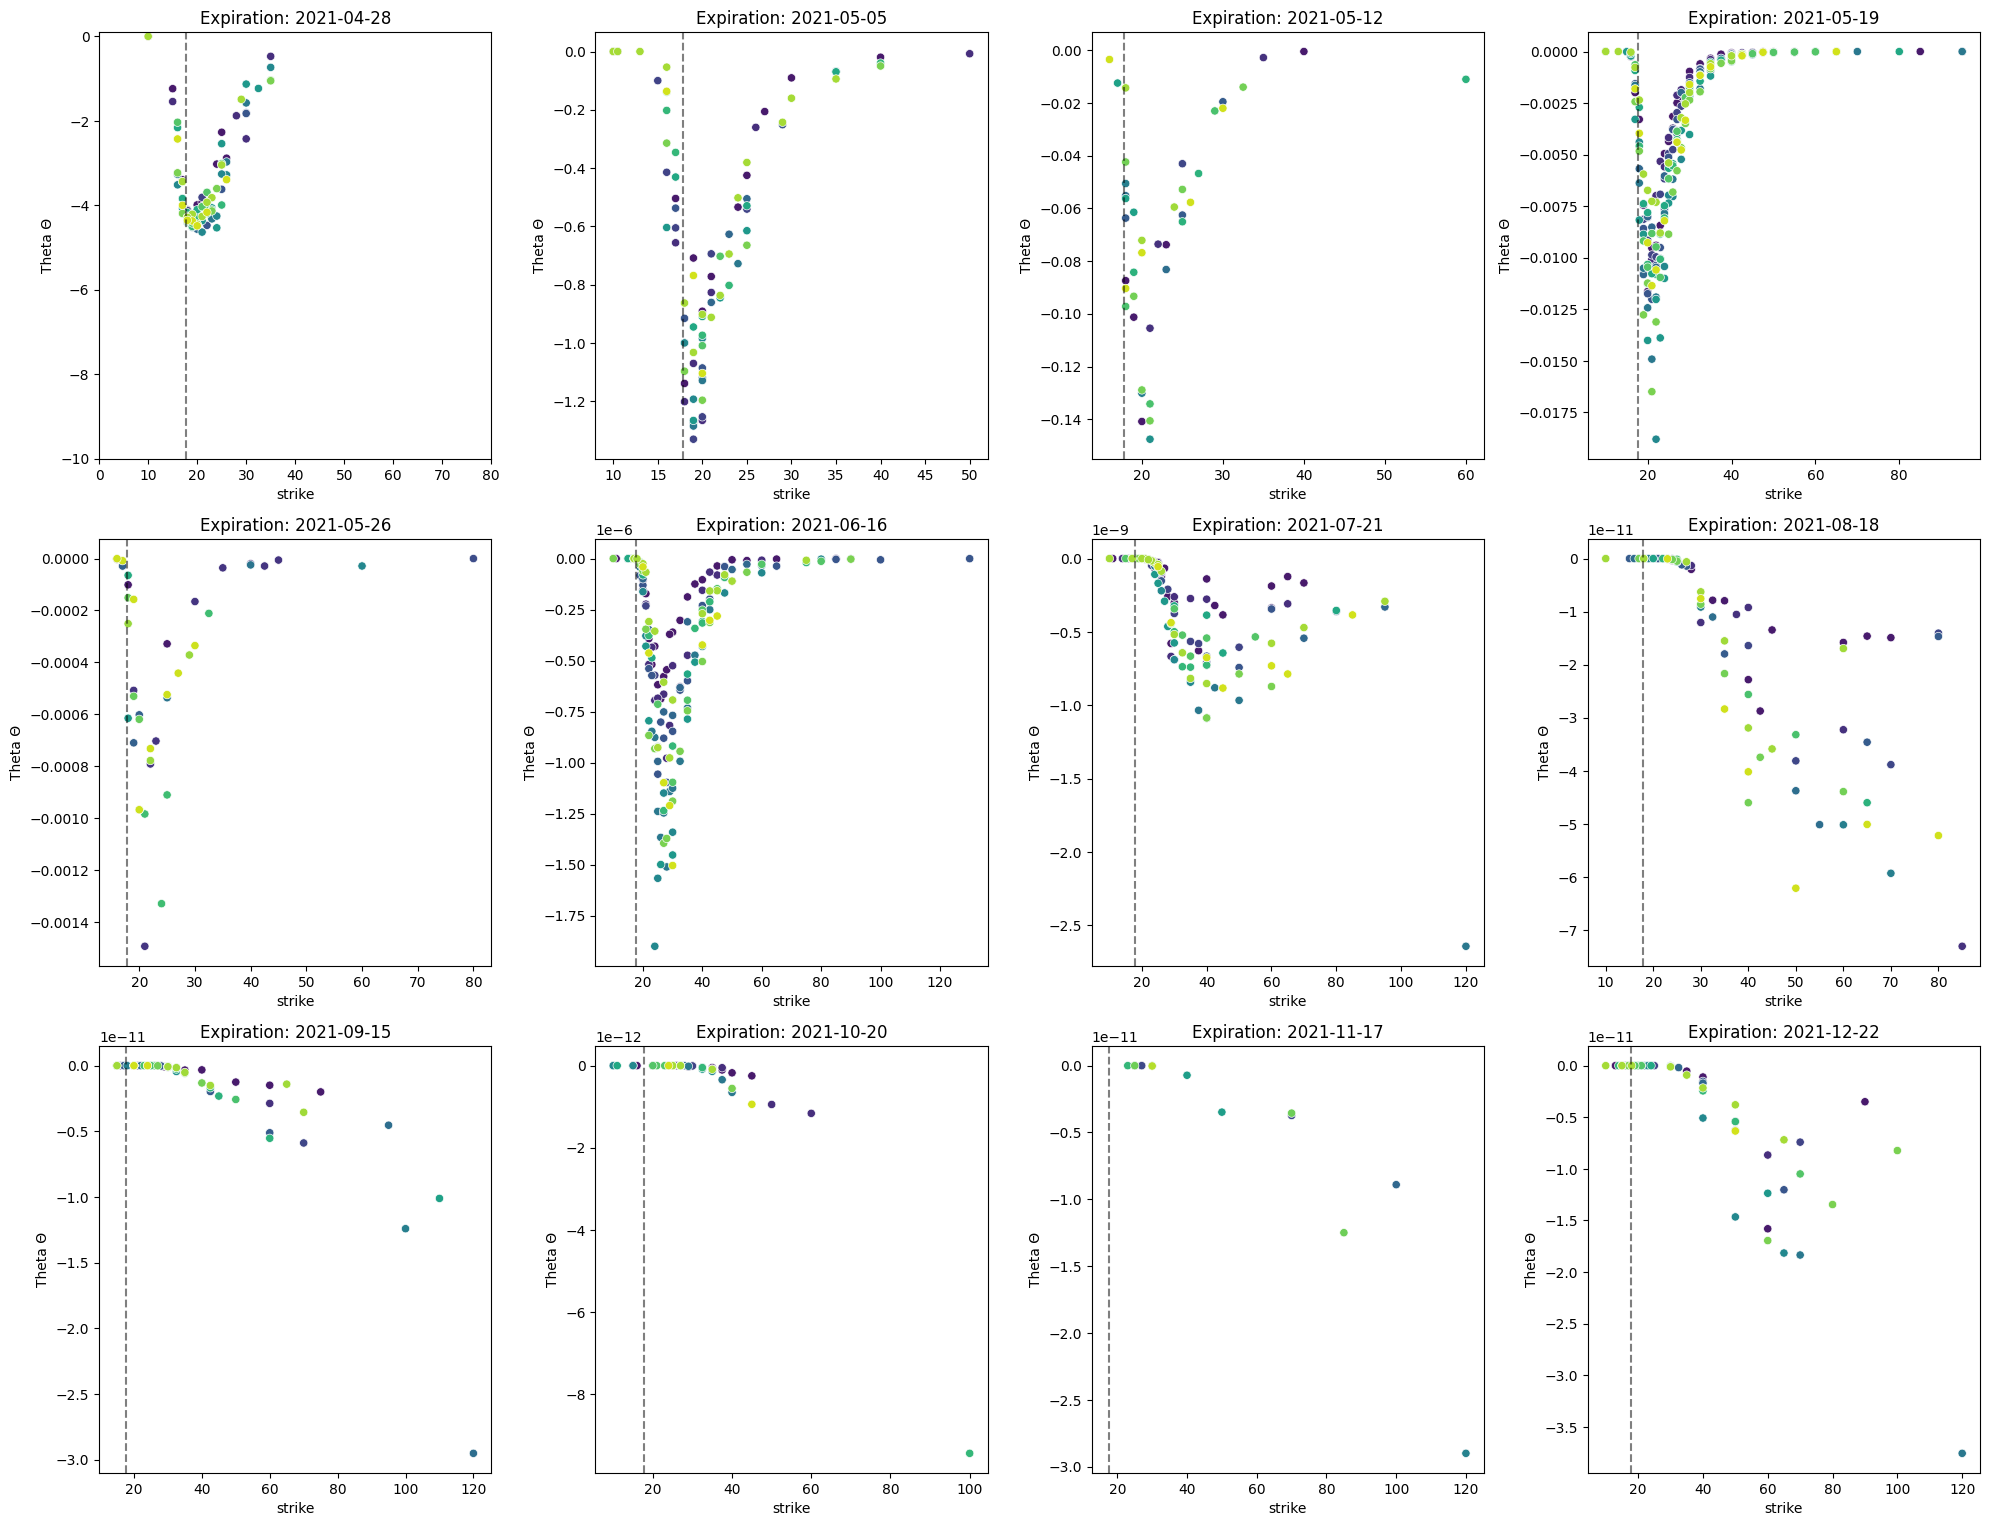

In [104]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='theta', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('Theta \u0398')
    if i == 0:
        axes[i].set_ylim(-10,0.1)
        axes[i].set_xlim(0, 80)
    axes[i].set_title(f'Expiration: {expiration}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

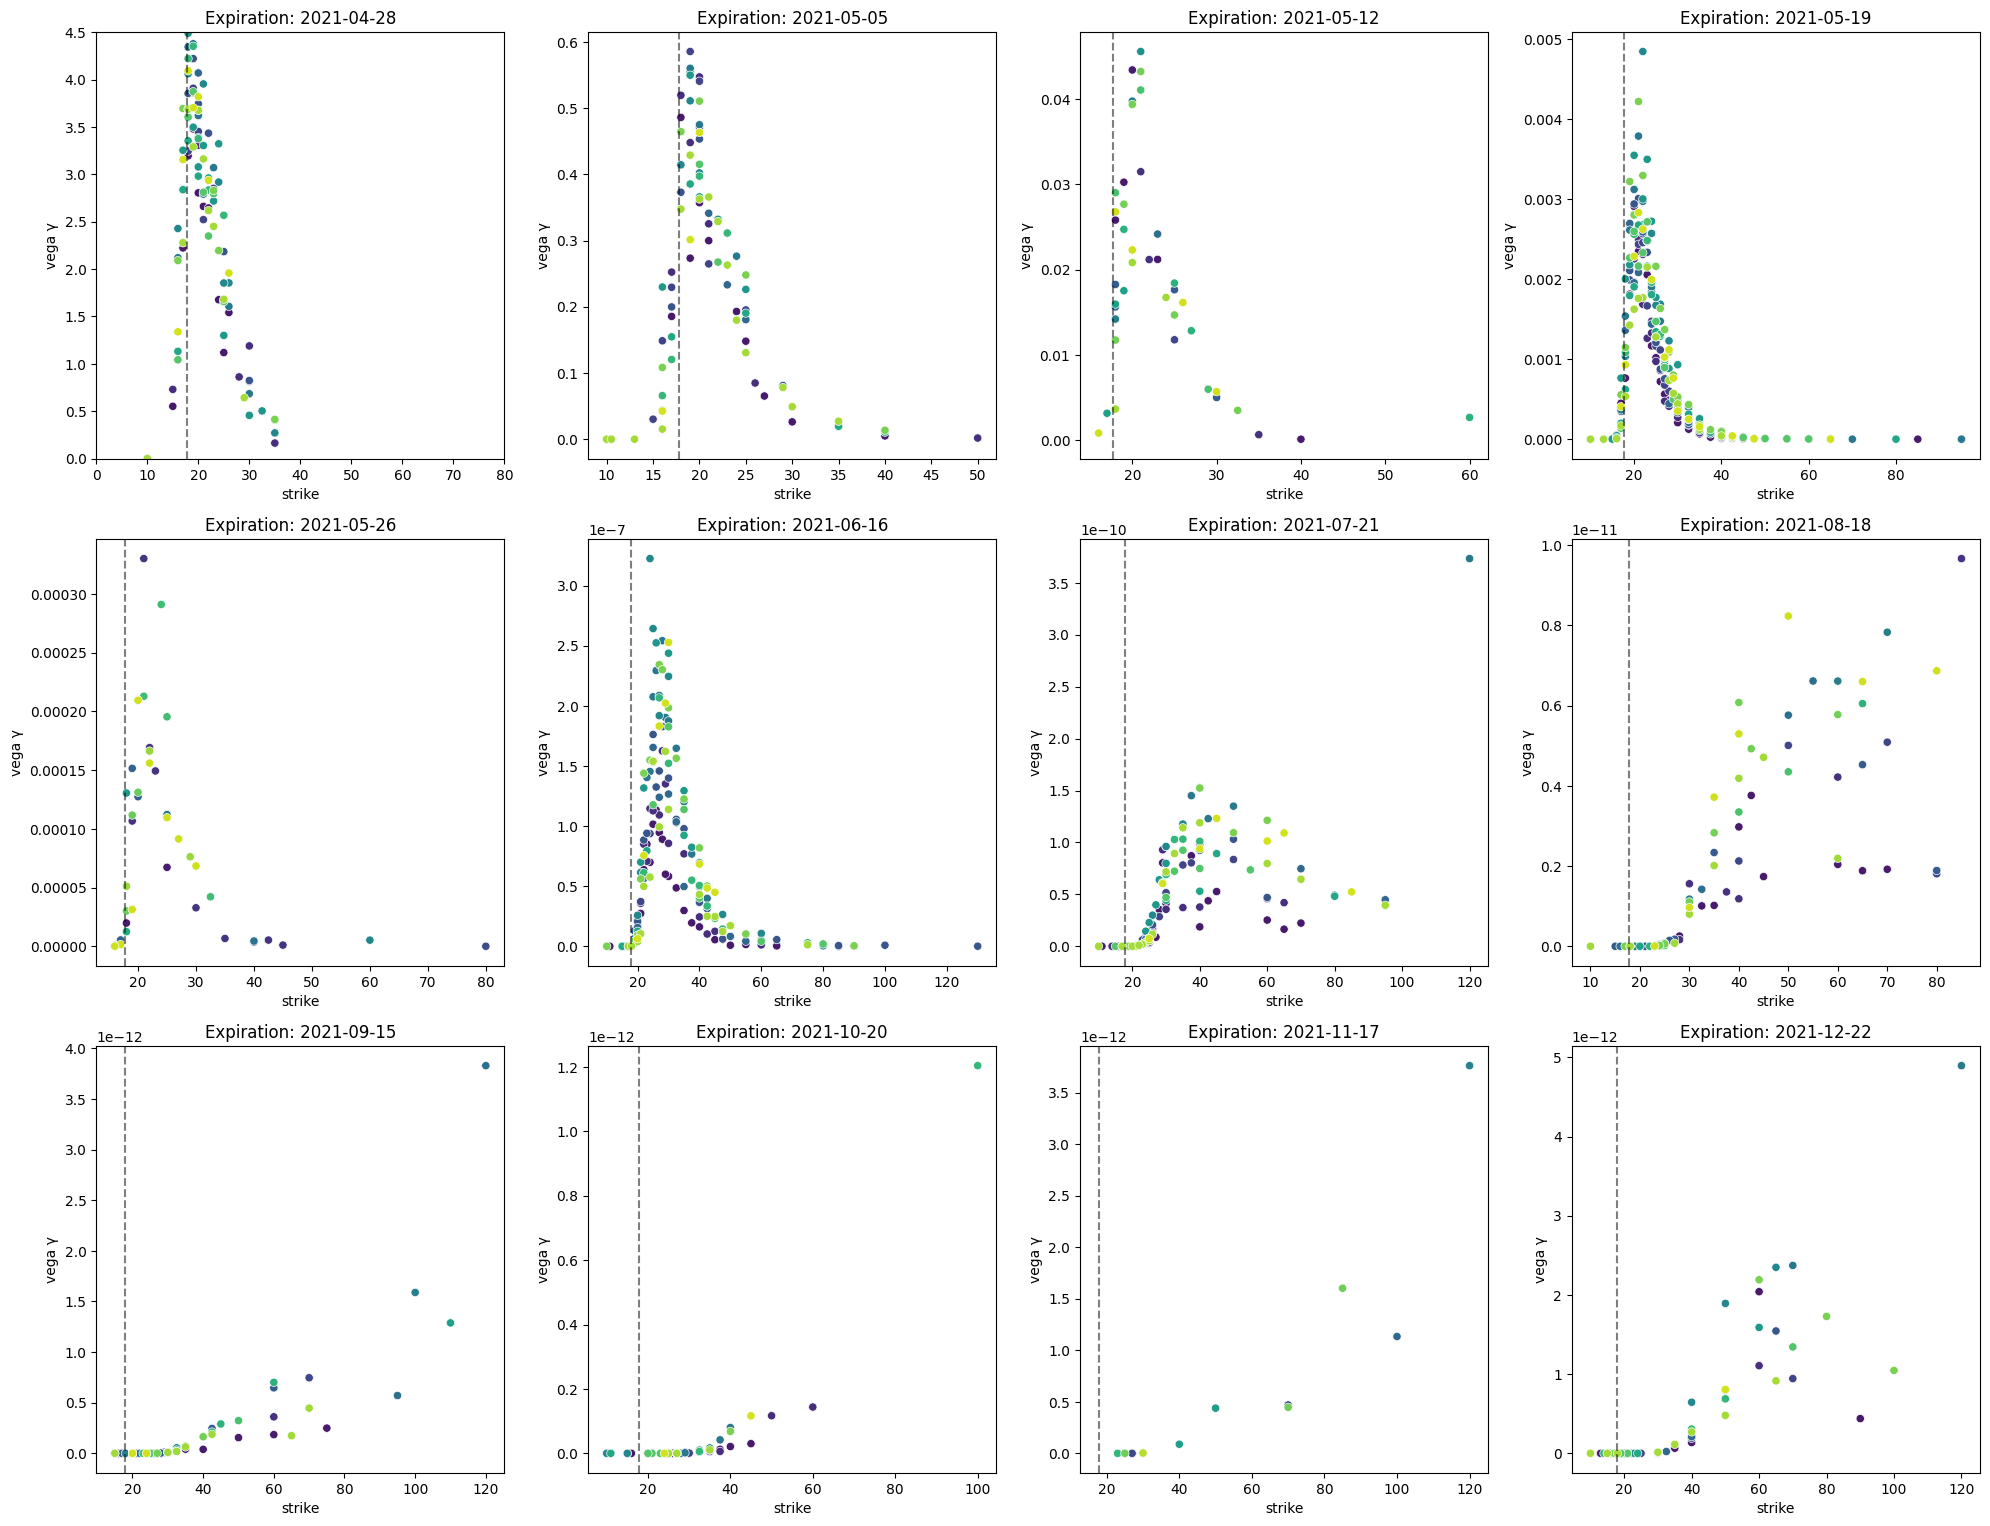

In [105]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='vega', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('vega \u03B3')
    if i == 0:
        axes[i].set_ylim(0,4.5)
        axes[i].set_xlim(0, 80)
    axes[i].set_title(f'Expiration: {expiration}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

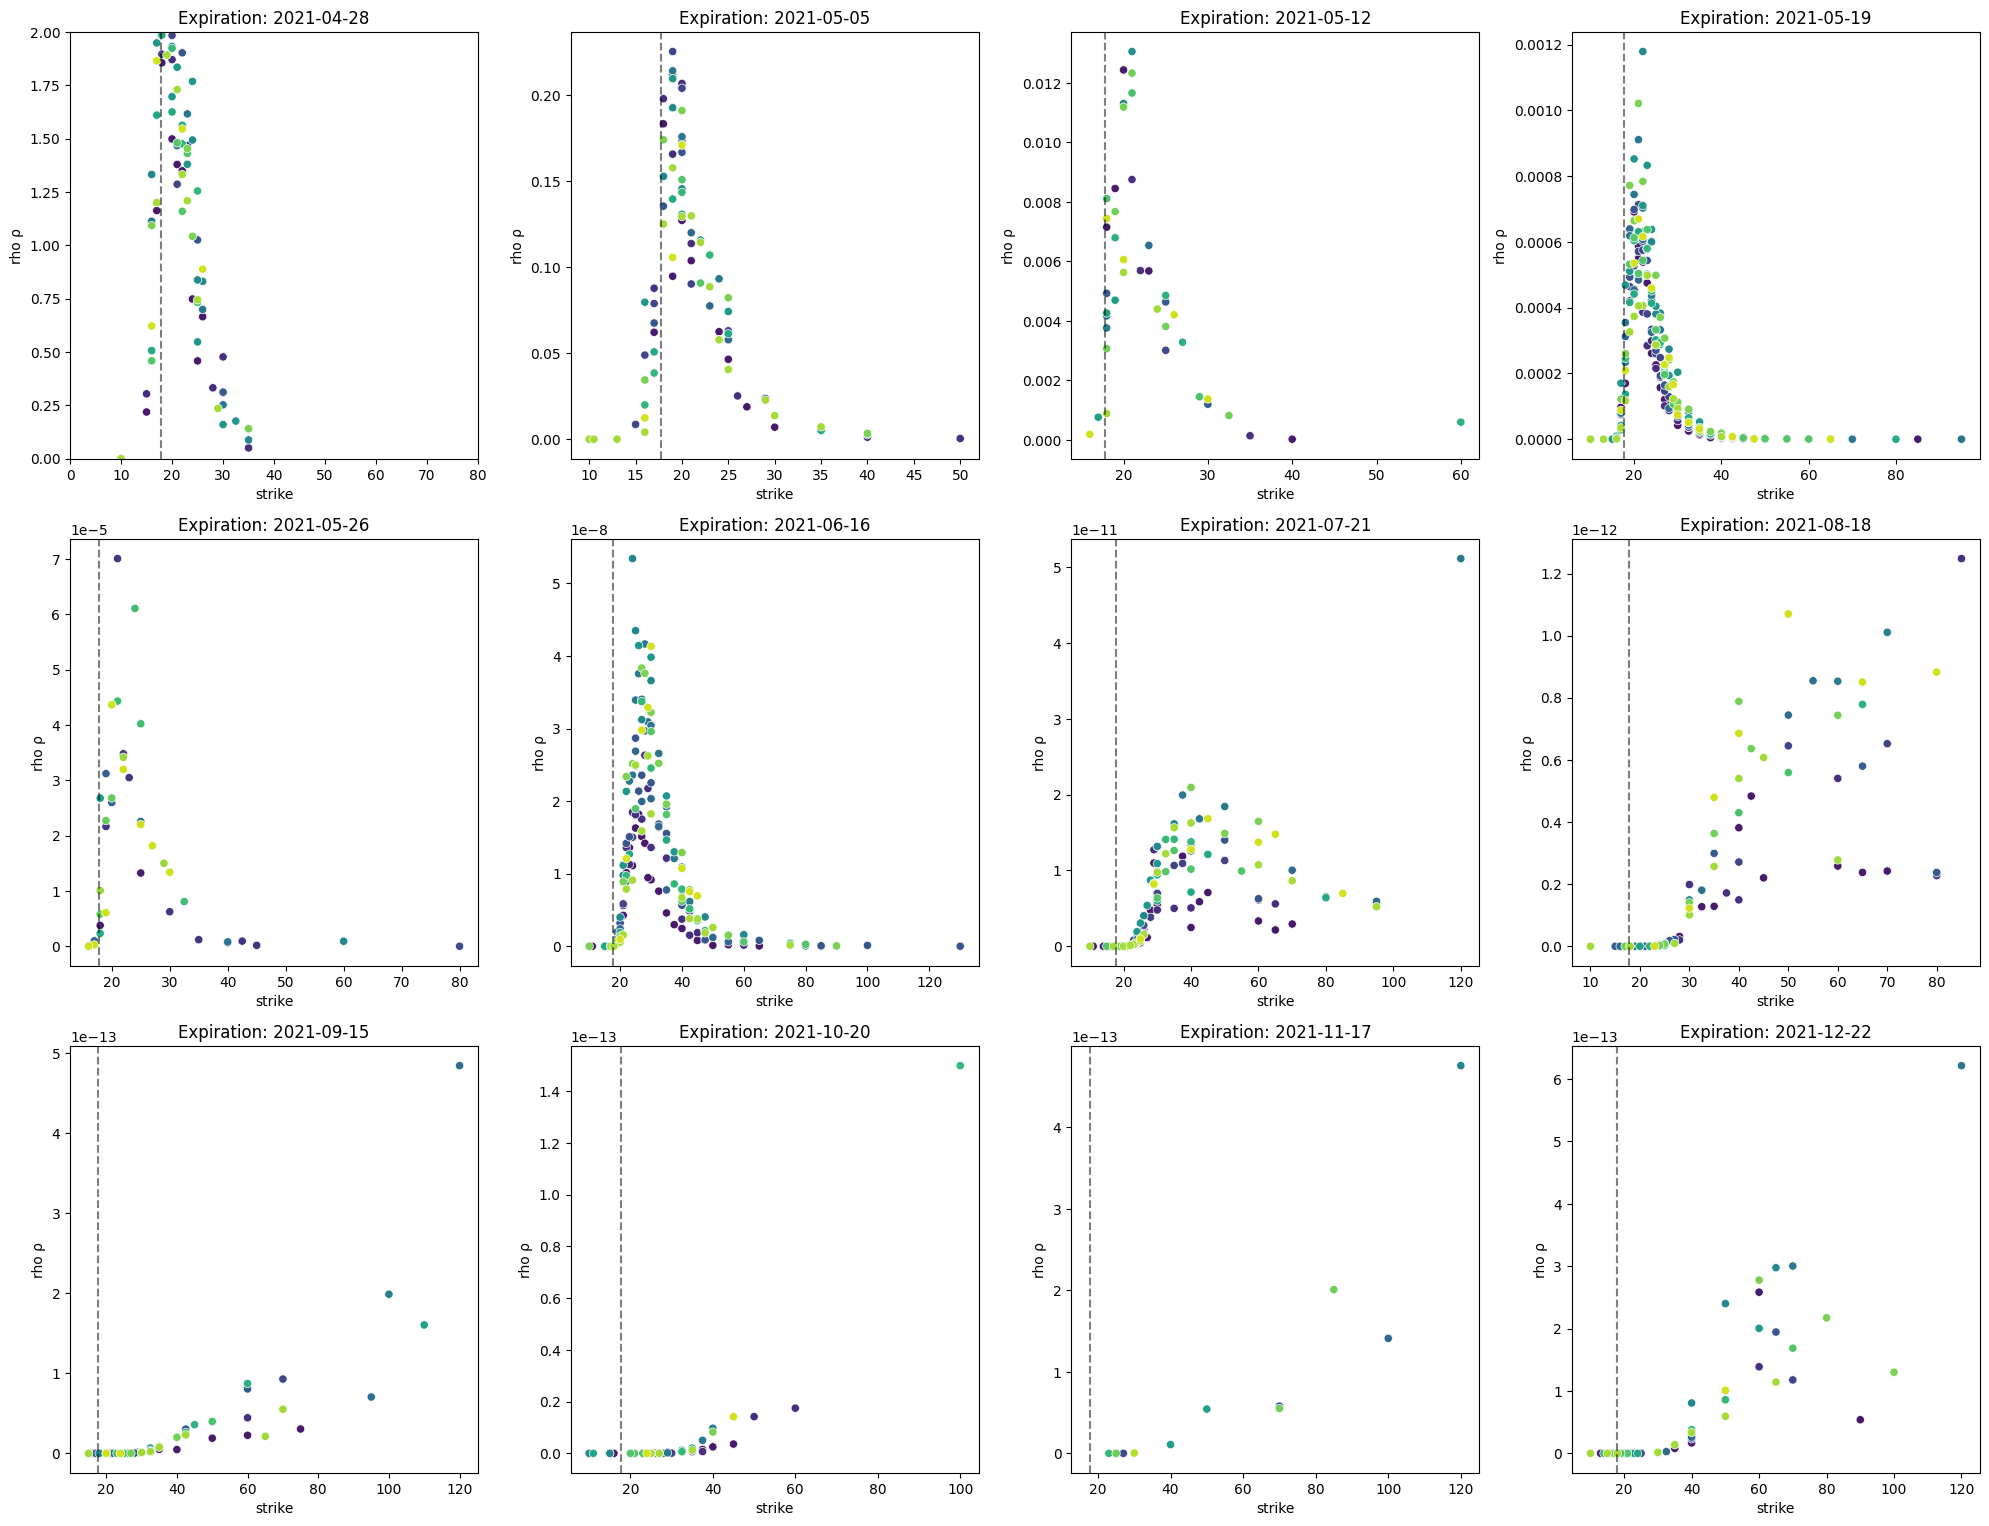

In [106]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

for i, expiration in enumerate(expirations):
    df = pd.read_csv(fr'impliedcalc\vix_options_{expiration}.csv')
    df = df[df['option_type'] =="C"]
    sns.scatterplot(x='strike', y='rho', hue='quote_datetime',
                     style='option_type', markers={'C': 'o', 'P': '*'},
                       data=df, palette='viridis', ax=axes[i])
    underlying_bid_avg = df['underlying_bid'].mean()
    axes[i].axvline(x=underlying_bid_avg, color='black', linestyle='--',alpha=0.5)
    axes[i].set_ylabel('rho \u03C1')
    if i == 0:
        axes[i].set_ylim(0,2)
        axes[i].set_xlim(0, 80)
    axes[i].set_title(f'Expiration: {expiration}') 
    axes[i].legend_.remove()

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()